# Kolmogorov-Arnold Networks(KAN)

This notebook aims to help in uderstanding KAN network by introducing B-slines, which are used as activation functions in KAN. We will look at toy examples and gradually build B-splines

** This notebook is tested with torch=2.6


The following series are:
* stacked splines
* grids
* symbolic learning

Original paper: [Liu et al. 2024, KAN: Kolmogorov-Arnold Networks](https://arxiv.org/abs/2404.19756)

## B-Splines 
### What are Splines?
Splines are a transformation that maps a set of control points to a regular, smooth curve. Given a series of such control pints, we aim to create a curve that generally follows the sahpe of these points. For example, given two control points (P0,P1), the curve function can be simply $P(t)=(1-t)P0+tP1$. This is an order 1 spline call 'lerp', $P(t)=lerp(P0,P1, t)$. By adding more control points, the smooth curve can be calulated recuresivly as $P(t)=lerp(lerp(P0,P1,t),lerp(P1,P2,t))$. If we write all these lerps out as a math function, we can see $P(t)={\color{red}{(1-2t+t^2)}}\cdot P0+{\color{green}{(1-t)t}}\cdot P1+{\color{purple}{t}}\cdot P2$. This shows us how basis function (in colors) controls the contribution of each control point to the curve function. The matrix form of four control points (order k=3) equation:
$$
P(t)=[1,t,t^2,t^3]\cdot
   {\color{red}{
      \begin{bmatrix} 
      1 & 0& 0& 0 \\
      -3 & 3& 0& 0 \\
      3 & -6& 3& 0 \\
      -1 & 3& -3& 1
      \end{bmatrix}
   }}\cdot
   \begin{bmatrix} P0 \\ P1 \\ P2 \\ P3
   \end{bmatrix}
$$
where the red matrix is called caracteristic matrix can be changed according to continuity C and geometric continuity G.
Best video to learn all types of splines is [here](https://www.youtube.com/watch?v=jvPPXbo87ds). 

### What are B-Splines?
A B-spline is defined by two parameters:

1. **Order (k)**: The curve's order.
    - k = 0: Uses the nearest control point directly. This lacks C0 continuity due to abrupt changes.
    - k = 1: Linearly interpolates between two control points.
    - k = 2: Uses a quadratic transformation to account for three control points.
    - k = 3: Applies a cubic transformation using four points, and so forth.
    
B-splines form a class of C2 continuous curves, meaning their second derivatives are continuous and well-defined everywhere. This fact lends KANs based on B-splines to be optimized using second-order optimization methods, such as LBFGS. To reach C2 continity, the caracteristic matrix 
The spline type used in KAN network is cubic transfromation spline with order k=3.

### How are B-splines used to learn activation functions?

KAN network Authors use learnable 2D B-splines to learn activation function for each feature. The features can be the raw input features or the outputs of intermediate layers that are fed into the subsequent layer. The control points (referred to as a `grid`) are specified in 1D. The spline order (often k=3) is fixed. The goal is to manipulate the influence of control points (through learnable coeffecients) to determine the y-values that result in the accurate prediction on the downstream task.


### B-Splines Mathematically

The workhorse of B-splines are basis functions $N_{i,k}(x): \mathcal{R} \rightarrow \mathcal{R}$ defined for each control point $i$ and the spline-order $k$. For a spline-order $k$, the scalar input $x \in \mathcal{R}$ is converted to "features" using the basis functions. These features are combined using learnable coefficients to result in a scalar output $\in \mathcal{R}$. 

**Cox-De Boor Recursion Formula**

The Cox-De Boor ***recursion formula*** provides a method to calculate the B-spline basis functions of degree $k$. 


**Base Case**

For $k=0$, the basis functions results in a one-hot encoding vector with a value of $1$ at the $i^{th}$ control point $t_i$ less than or equal to the scalar input $x$.

$$
N_{i,0}(x) = 
   \begin{cases} 
   1 & \text{if } t_i \leq x < t_{i+1} \\
   0 & \text{otherwise}
   \end{cases}
$$

If we define M control points, $i \in \{0, 1, 2, ..., M-1\}$, there will be a total of $M$ features corresponding to each scalar input $x$.

**Recursive Step**

The subsequent cases results in features described as follows

$ N_{i,k}(x) = \frac{x - t_i}{t_{i+k} - t_i} N_{i,k-1}(x) + \frac{t_{i+k+1} - x}{t_{i+k+1} - t_{i+1}} N_{i+1,k-1}(x) $

Here, for M control points, $i \in \{0, 1, 2, ..., M-k-1\}$, resulting in a total of $M-k$ basis functions for each scaler input. Authors of KAN use the extension of `grid` to increase the control points at the two extremes, resulting in a total of $M$ basis functions and hence $M$ learnable coefficients for each B-spline. We will see the effect of grid extension later in this tutorial.

## Notes:
- The control points $t_i$ must be non-decreasing.
- Each basis function $N_{i,k}(x)$ is non-zero only within the interval $ [t_i, t_{i+k+1}]$.
- ***Why does it generate smooth and continuous curves?***:  The B-spline curves are constructed by linearly combining the basis functions with control points. This also result in continuous curves exhbiting a key property of locality. This means that modifying a specific section of the curve, for example, from \(t_2\) to \(t_5\), does not affect the remainder of the curve. This localized influence is why KANs are resistant to catastrophic forgetting, as the input from various data distributions only impacts the curve locally.



### B-Splines programm

In [2]:
import torch
import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt

In [3]:
# Here, we define the control points. 
grid = torch.linspace(-1, 1, steps=10)

# we take the entire domain to plot the basis function as a function of x
x = torch.linspace(-1, 1, steps=1000) 

print(f"Grid: Shape:{grid.shape}, values:", grid)
print(f"x: Shape:{x.shape}, values:", x[:5])

# Reshape so that each x can be compared to each control point
grid_ = grid.unsqueeze(dim=0)
x_ = x.unsqueeze(dim=1)

# Base case
k = 0
value1 = (x_ >= grid_[:,:-1]) * (x_ < grid_[:, 1:])

# Other cases
k = 1 # This gives us basis functions for order 1
value21 = (x_ - grid_[:, :-(k+1)]) / (grid_[:, 1:-k] - grid_[:, :-(k+1)]) * value1[:, :-1]
value22 = (grid_[:, (k+1):] - x_) / (grid_[:, (k+1):] - grid_[:, 1:-k]) * value1[:, 1:]
value2 = value21 + value22

k = 2 # This gives us basis functions for order 2
value31 = (x_ - grid_[:, :-(k+1)]) / (grid_[:, 1:-k] - grid_[:, :-(k+1)]) * value2[:, :-1]
value32 = (grid_[:, (k+1):] - x_) / (grid_[:, (k+1):] - grid_[:, 1:-k]) * value2[:, 1:]
value3 = value31 + value32

k = 3 # This gives us basis functions for order 3
value41 = (x_ - grid_[:, :-(k+1)]) / (grid_[:, 1:-k] - grid_[:, :-(k+1)]) * value3[:, :-1]
value42 = (grid_[:, (k+1):] - x_) / (grid_[:, (k+1):] - grid_[:, 1:-k]) * value3[:, 1:]
value4 = value41 + value42

print(f"k=0, number of basis functions: {value1.shape[-1]}")
print(f"k=1, number of basis functions: {value2.shape[-1]}")
print(f"k=2, number of basis functions: {value3.shape[-1]}")
print(f"k=3, number of basis functions: {value4.shape[-1]}")

Grid: Shape:torch.Size([10]), values: tensor([-1.0000, -0.7778, -0.5556, -0.3333, -0.1111,  0.1111,  0.3333,  0.5556,
         0.7778,  1.0000])
x: Shape:torch.Size([1000]), values: tensor([-1.0000, -0.9980, -0.9960, -0.9940, -0.9920])
k=0, number of basis functions: 9
k=1, number of basis functions: 8
k=2, number of basis functions: 7
k=3, number of basis functions: 6


The following plot will plot only the first 4 basis functions in each order. You can change the number of basis funtions by editing n_basis_to_plot.

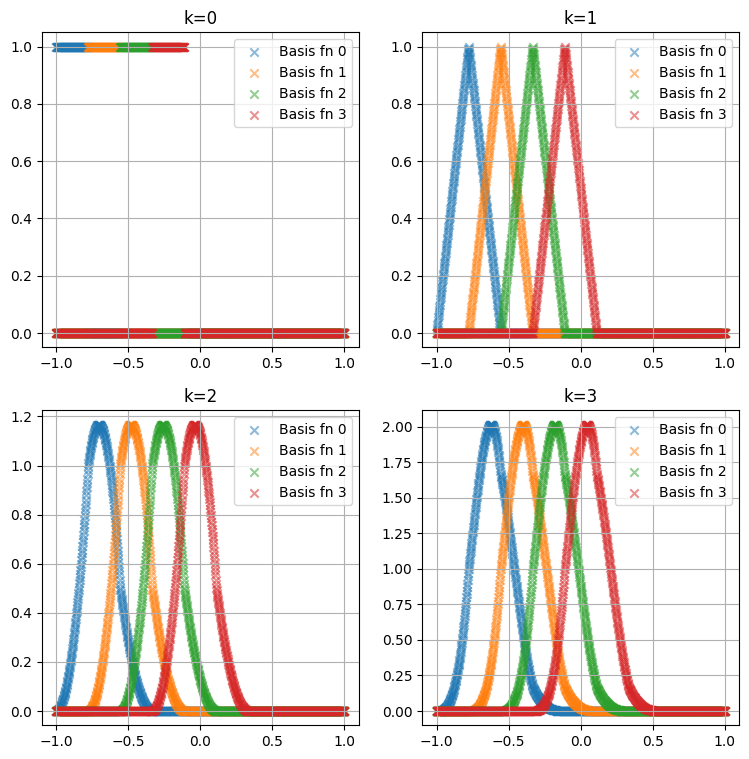

In [4]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(9, 9), dpi=100)

n_basis_to_plot = 4
all_basis = [(value1, 'k=0'), (value2, 'k=1'), (value3, 'k=2'), (value4, 'k=3')]
for i in range(4):
    
    ax = axs[i // 2, i % 2] 

    value, label = all_basis[i]
    for idx in range(value.shape[-1])[:n_basis_to_plot]:
        ax.scatter(x, value[:, idx], marker='x', label=f"Basis fn {idx}", alpha=0.5)
    ax.grid()
    ax.set_title(label)
    ax.legend()

**Observations**

- There are a total of $\#control\_points - k - 1$ basis functions. Think of these basis functions as features for a particular scalar input. 
- Each basis function is non-zero over a specific range, defined by the corresponding control points
- $K = 0$ has step basis functions as expected for one-hot encoded vectors
- $K = 1$ has piecewise linear basis functions
- $K \geq 2$ has non-linear basis functions

#### Extending the Grid for B-Splines Programatically

We also observe that not all inputs have the same number of non-zero basis functions. For instance, the basis functions near the boundaries of the input domain often have fewer non-zero basis functions. To address this, the authors extend the grid, ensuring that all features within the input domain have an equal number of non-zero basis functions.

The grid is extended by $k$ control points on each side, allowing the points at the extremes to have the same number of basis functions as those within the central part of the domain.

Next, let's explore how this extension is implemented programmatically. We extend grid once in the beginning of the evaluation. 

In [5]:
def extend_grid(grid, k):
    """
    Extends the grid on either size by k steps

    Args:
        grid: number of splines x number of control points
        k: spline order

    Returns:
        new_grid: number of splines x (number of control points + 2 * k)
    """
    n_intervals = grid.shape[-1] - 1
    bucket_size = (grid[:, -1] - grid[:, 0]) / n_intervals
    
    for i in range(k):
        grid = torch.cat([grid[:, :1] - bucket_size, grid], dim=-1)
        grid = torch.cat([grid, grid[:, -1:] + bucket_size], dim=-1)

    return grid

In [6]:
def eval_basis_functions(x_eval, grid, k):
    """
    Returns the value of basis functions defiend for order-k splines and control points defined in `grid`. 

    Args:
        x_eval: number of samples x number of dimensions
        grid: number of splines x number of control points
        k (scalar): order of spline

    Returns:
        bases: number of samples x number of dimensions x number of basis functions
    """
    grid_ = extend_grid(grid, k)
    # Reshape so that each x can be compared to each control point
    grid_ = grid_.unsqueeze(dim=2)
    x_ = x_eval.unsqueeze(dim=1)
    
    for idx in range(k+1):
        if idx == 0:
            bases = (x_ >= grid_[:, :-1]) * (x_ < grid_[:, 1:]) * 1.0 # step function; for each x in between the corresponding knots, the value is 1.
        else:
            bases1 = (x_ - grid_[:, :-(idx+1)]) / (grid_[:, 1:-idx] - grid_[:, :-(idx+1)]) * bases[:, :-1]
            bases2 = (grid_[:, (idx+1):] - x_) / (grid_[:, (idx+1):] - grid_[:, 1:-idx]) * bases[:, 1:]
            bases = bases1 + bases2

    return bases.transpose(1, 2) * 1.0

Grid: Shape:torch.Size([10]), values: tensor([-1.0000, -0.7778, -0.5556, -0.3333, -0.1111,  0.1111,  0.3333,  0.5556,
         0.7778,  1.0000])
x: Shape:torch.Size([1000]), values: tensor([-1.0000, -0.9980, -0.9960, -0.9940, -0.9920])
k=0, number of basis functions: 9
k=1, number of basis functions: 10
k=2, number of basis functions: 11
k=3, number of basis functions: 12


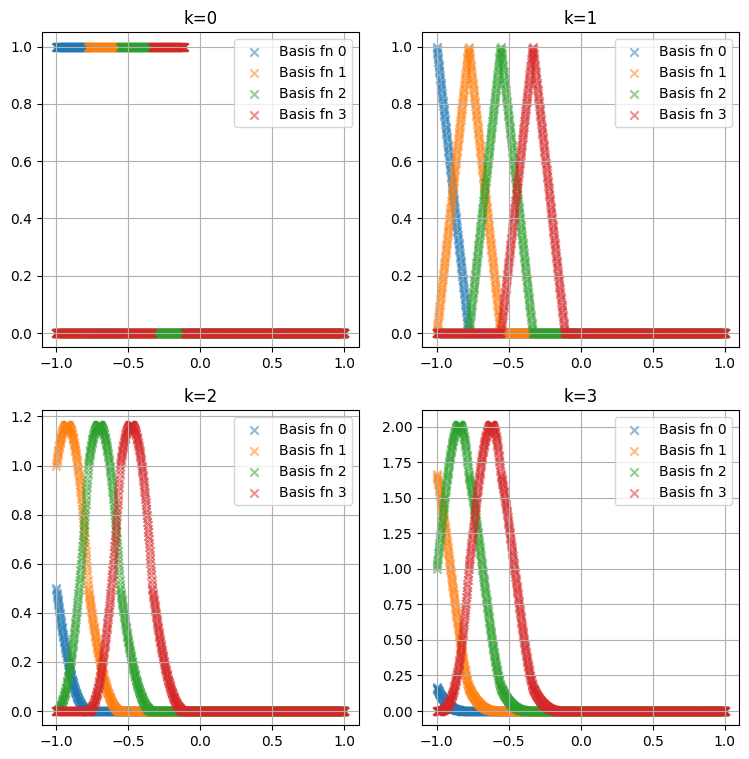

In [7]:
grid = torch.linspace(-1, 1, steps=10)
x = torch.linspace(-1, 1, steps=1000) # we take the entire domain to plot the basis function as a function of x

print(f"Grid: Shape:{grid.shape}, values:", grid)
print(f"x: Shape:{x.shape}, values:", x[:5])

# Reshape so that each x can be compared to each control point
grid_ = grid.unsqueeze(dim=0)
x_ = x.unsqueeze(dim=1)


value1 = eval_basis_functions(x_, grid_, k=0)

value2 = eval_basis_functions(x_, grid_, k=1)

value3 = eval_basis_functions(x_, grid_, k=2)

value4 = eval_basis_functions(x_, grid_, k=3)

print(f"k=0, number of basis functions: {value1.shape[-1]}")
print(f"k=1, number of basis functions: {value2.shape[-1]}")
print(f"k=2, number of basis functions: {value3.shape[-1]}")
print(f"k=3, number of basis functions: {value4.shape[-1]}")


fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(9, 9), dpi=100)

n_basis_to_plot = 4
all_basis = [(value1, 'k=0'), (value2, 'k=1'), (value3, 'k=2'), (value4, 'k=3')]
for i in range(4):
    
    ax = axs[i // 2, i % 2] 

    value, label = all_basis[i]
    for idx in range(value.shape[-1])[:n_basis_to_plot]:  
        ax.scatter(x, value[:, 0, idx], marker='x', label=f"Basis fn {idx}", alpha=0.5)
    ax.grid()
    ax.set_title(label)
    ax.legend()

Finally, we see that even the boundary points get the same number of non-zero basis functions.

#### Learning the Activation Function, i.e., Coefficients

Now, let's explore whether we can learn the coefficients to emulate certain well-defined functions, with or without noise.

Formally, we define $ f(x) = \sum_{i=0}^{n} c_i \cdot N_{i, k}(x) = \sum_{i=0}^{n} c_i \cdot N_i(x) $.

Given $ x $, we will compute $ N_i(x) $ deterministically. Since we already have a predefined $ f(x) $, this presents a straightforward linear equation model to solve these equations: $ \min_{\mathbf{c}} |\mathbf{Nc} - f(x)| $. We will use `torch.linalg.lstsq` to solve for $ \mathbf{c} $.

Next, let's explore how to use a zero-order spline for predictions.

In [11]:
fn = lambda x: torch.sin(torch.pi * x) # define a function that we need to match
coeff1 = torch.linalg.lstsq(value1.squeeze(1), fn(x)).solution #find the coefficients

y_pred = torch.einsum('i,ji->j',coeff1,value1.squeeze(1))
plt.scatter(x,y_pred)

RuntimeError: torch.linalg.lstsq: Expected input and other to have the same dtype, but got input's dtype Bool and other's dtype Float

#### How does $k$ impact the learning accuracy?

Let's see the effect of order on estimations of various functions.

We consider two functions -- 
1. $\sin(\pi \times x)$
2. $\sin(\pi \times e^{x})$

We consider four values of $k \in \{0, 1, 2, 3\}$.

**Case 1:** When we don't extend the grid

<>:29: SyntaxWarning: invalid escape sequence '\p'
<>:30: SyntaxWarning: invalid escape sequence '\p'
<>:29: SyntaxWarning: invalid escape sequence '\p'
<>:30: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_59691/3799085821.py:29: SyntaxWarning: invalid escape sequence '\p'
  fns += [(lambda x: torch.sin(torch.pi * x), '$f(x) = sin(\pi*x)$')]
/tmp/ipykernel_59691/3799085821.py:30: SyntaxWarning: invalid escape sequence '\p'
  fns += [(lambda x: torch.sin(torch.pi * torch.exp(x)), '$f(x) = sin(\pi*e^{x})$')]


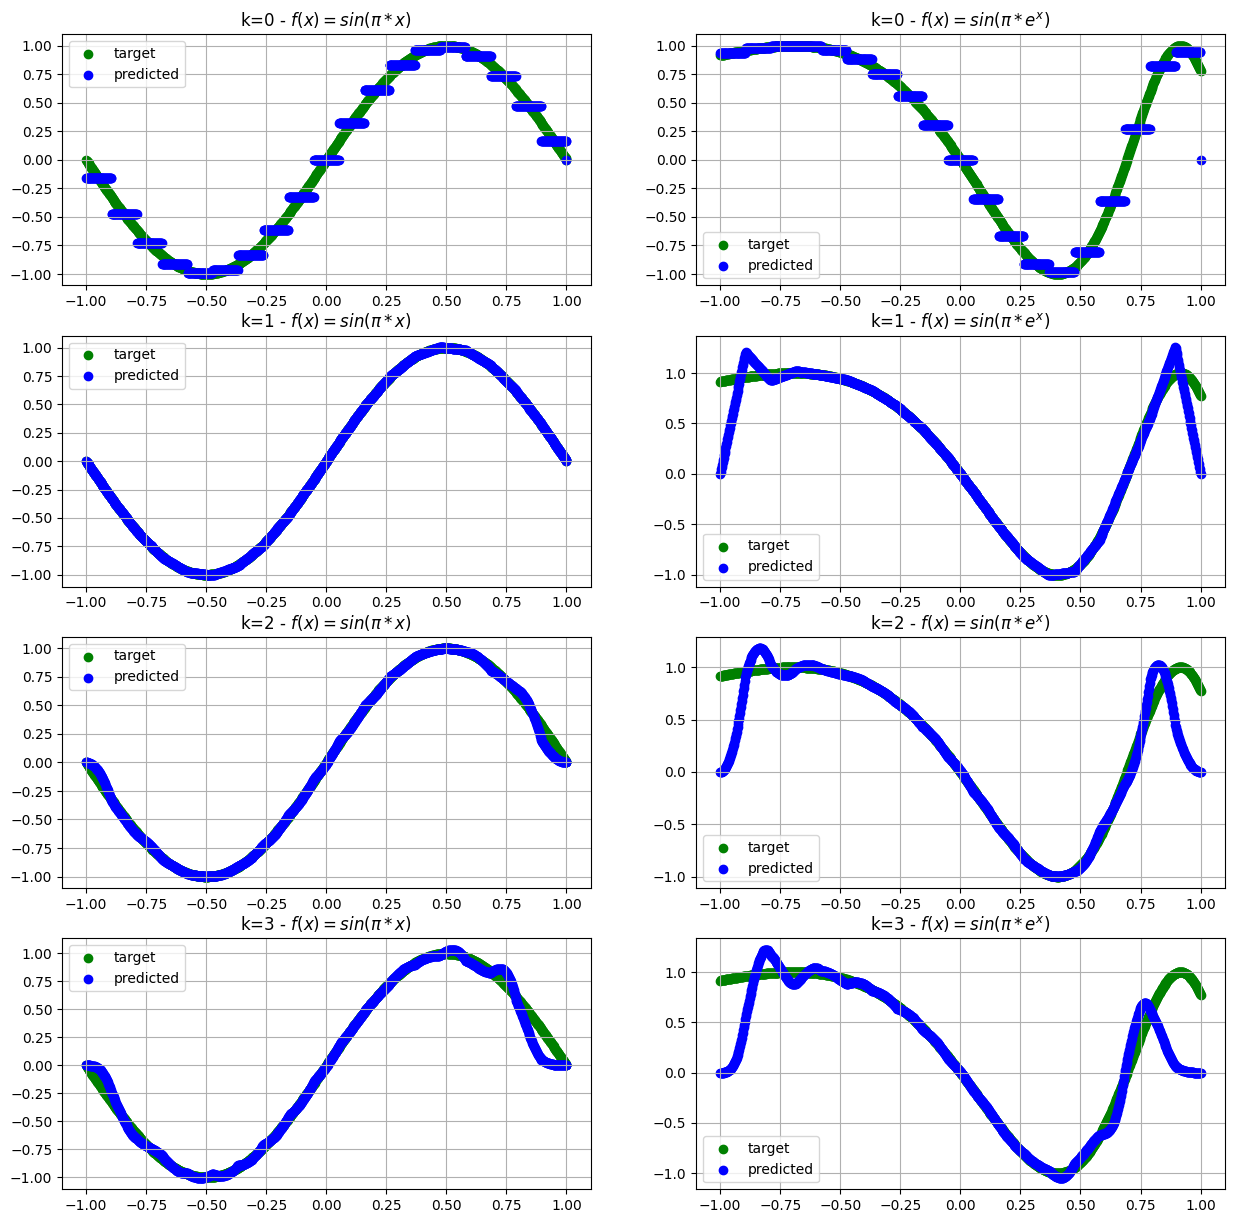

In [10]:
# notice the increase in the grid points to 100
grid = torch.linspace(-1, 1, steps=20) 
x = torch.linspace(-1, 1, steps=1000) # we take the entire domain to plot the basis function as a function of x

# Reshape so that each x can be compared to each control point
grid_ = grid.unsqueeze(dim=0)
x_ = x.unsqueeze(dim=1)

k = 0 # This gives us basis functions for order 0
value1 = (x_ >= grid_[:,:-1]) * (x_ < grid_[:, 1:])

k = 1 # This gives us basis functions for order 1
value21 = (x_ - grid_[:, :-(k+1)]) / (grid_[:, 1:-k] - grid_[:, :-(k+1)]) * value1[:, :-1]
value22 = (grid_[:, (k+1):] - x_) / (grid_[:, (k+1):] - grid_[:, 1:-k]) * value1[:, 1:]
value2 = value21 + value22

k = 2 # This gives us basis functions for order 2
value31 = (x_ - grid_[:, :-(k+1)]) / (grid_[:, 1:-k] - grid_[:, :-(k+1)]) * value2[:, :-1]
value32 = (grid_[:, (k+1):] - x_) / (grid_[:, (k+1):] - grid_[:, 1:-k]) * value2[:, 1:]
value3 = value31 + value32

k = 3 # This gives us basis functions for order 3
value41 = (x_ - grid_[:, :-(k+1)]) / (grid_[:, 1:-k] - grid_[:, :-(k+1)]) * value3[:, :-1]
value42 = (grid_[:, (k+1):] - x_) / (grid_[:, (k+1):] - grid_[:, 1:-k]) * value3[:, 1:]
value4 = value41 + value42


fns = []
fns += [(lambda x: torch.sin(torch.pi * x), '$f(x) = sin(\pi*x)$')]
fns += [(lambda x: torch.sin(torch.pi * torch.exp(x)), '$f(x) = sin(\pi*e^{x})$')]

all_basis = [(value1 * 1.0, 'k=0'), (value2, 'k=1'), (value3, 'k=2'), (value4, 'k=3')]

fig, axs = plt.subplots(ncols=len(fns), nrows=len(all_basis), figsize=(15, 15), dpi=100)

for i in range(len(all_basis)):
    for j in range(len(fns)):
    
        ax = axs[i, j] 
        value, label = all_basis[i]
        fn, fn_label = fns[j]
        
        coeff = torch.linalg.lstsq(value, fn(x)).solution # find the coefficients 
        y_pred = torch.einsum('i, ji -> j', coeff, value) # use these coefficients to evaluate y
        
        ax.scatter(x, fn(x), color='green', label='target')
        ax.scatter(x, y_pred, color='blue', label="predicted")

        ax.grid()
        ax.set_title(f"{label} - {fn_label}")
        ax.legend()

**Observations**

1. As $ k $ increases, the fit near the boundaries is not perfect due to boundary effects, as previously discussed. There are insufficient boundary points in these areas. This issue can be minimized by increasing the number of control points, as we will explore next.
2. As $ k $ increases, the fit improves significantly in the middle of the domain.

**Case 2:** When we extend the grid on either side

<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:3: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:3: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_59691/749890961.py:2: SyntaxWarning: invalid escape sequence '\p'
  fns += [(lambda x: torch.sin(torch.pi * x), '$f(x) = sin(\pi*x)$')]
/tmp/ipykernel_59691/749890961.py:3: SyntaxWarning: invalid escape sequence '\p'
  fns += [(lambda x: torch.sin(torch.pi * torch.exp(x)), '$f(x) = sin(\pi*e^{x})$')]


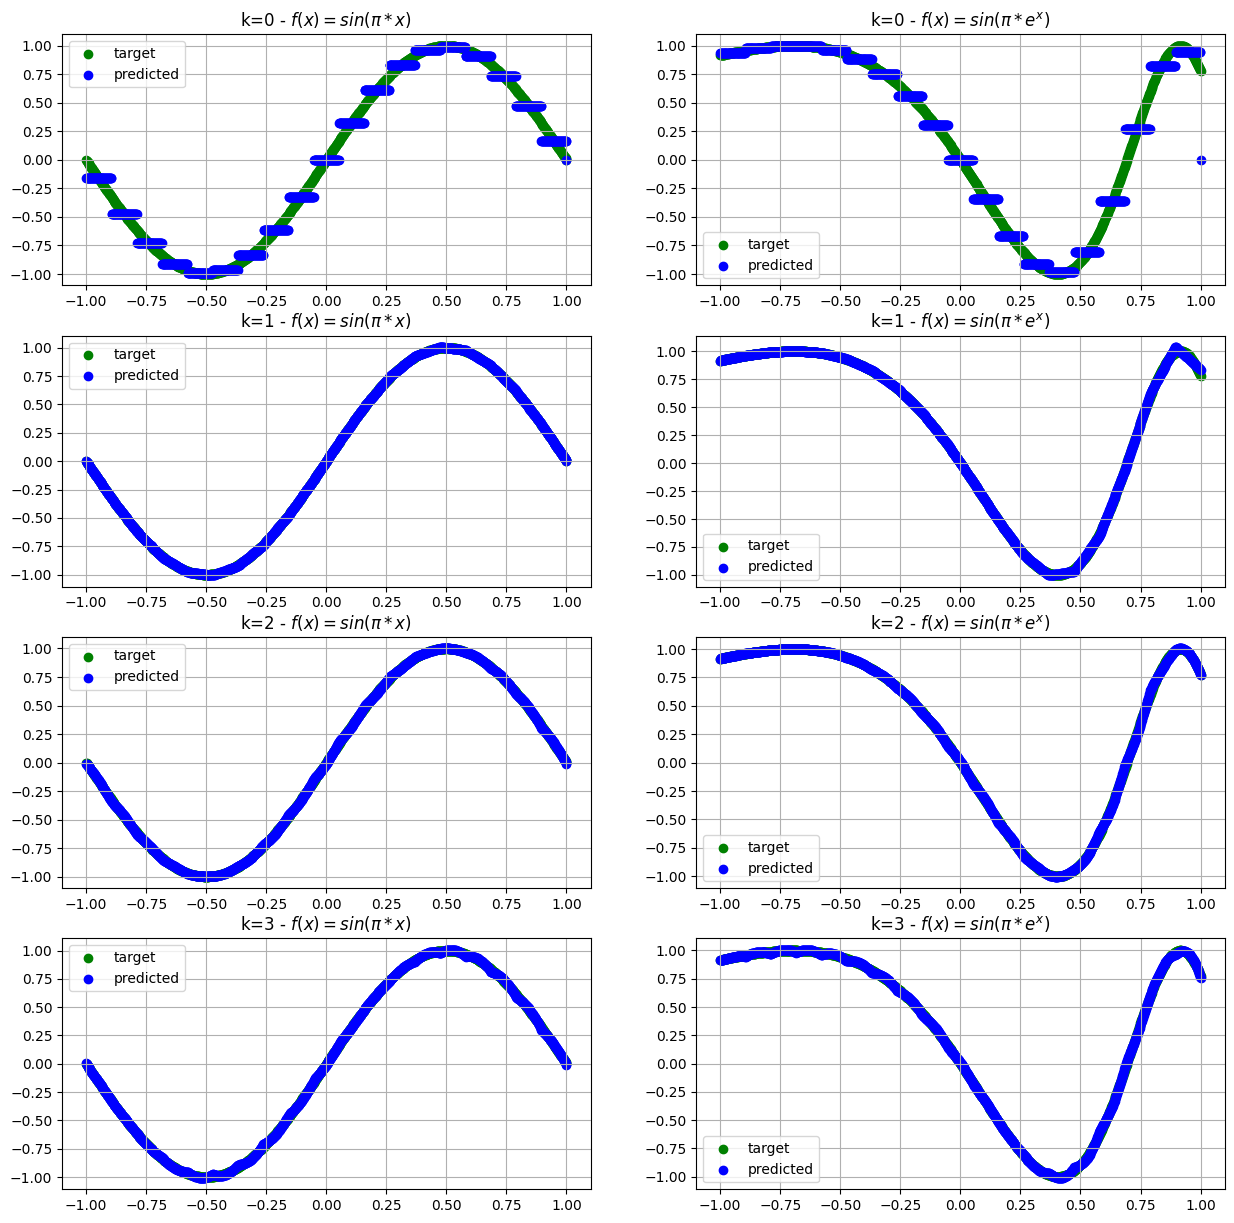

In [12]:
fns = []
fns += [(lambda x: torch.sin(torch.pi * x), '$f(x) = sin(\pi*x)$')]
fns += [(lambda x: torch.sin(torch.pi * torch.exp(x)), '$f(x) = sin(\pi*e^{x})$')]

all_basis = [
        (eval_basis_functions(x_, grid_, k=0), 'k=0'), 
        (eval_basis_functions(x_, grid_, k=1), 'k=1'), 
        (eval_basis_functions(x_, grid_, k=2), 'k=2'), 
        (eval_basis_functions(x_, grid_, k=3), 'k=3')
]

fig, axs = plt.subplots(ncols=len(fns), nrows=len(all_basis), figsize=(15, 15), dpi=100)

for i in range(len(all_basis)):
    for j in range(len(fns)):
    
        ax = axs[i, j] 
        value, label = all_basis[i]
        fn, fn_label = fns[j]
        
        coeff = torch.linalg.lstsq(value.squeeze(1), fn(x)).solution # find the coefficients 
        y_pred = torch.einsum('i, ji -> j', coeff, value.squeeze(1)) # use these coefficients to evaluate y
        
        ax.scatter(x, fn(x), color='green', label='target')
        ax.scatter(x, y_pred, color='blue', label="predicted")

        ax.grid()
        ax.set_title(f"{label} - {fn_label}")
        ax.legend()

Notice how increasing the number of control points has improved the overall fit near the boundaries. 

**Case 3:** Usually, the real data is messy. How will the noise in the function estimation look like?


<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:3: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:3: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_59691/2580022276.py:2: SyntaxWarning: invalid escape sequence '\p'
  fns += [(lambda x: torch.sin(torch.pi * x) + 0.1 * torch.randn(x.shape), '$f(x) = sin(\pi*x) + \epsilon$')]
/tmp/ipykernel_59691/2580022276.py:3: SyntaxWarning: invalid escape sequence '\p'
  fns += [(lambda x: torch.sin(torch.pi * torch.exp(x)) + 0.1 * torch.randn(x.shape), '$f(x) = sin(\pi*e^{x}) + \epsilon$')]


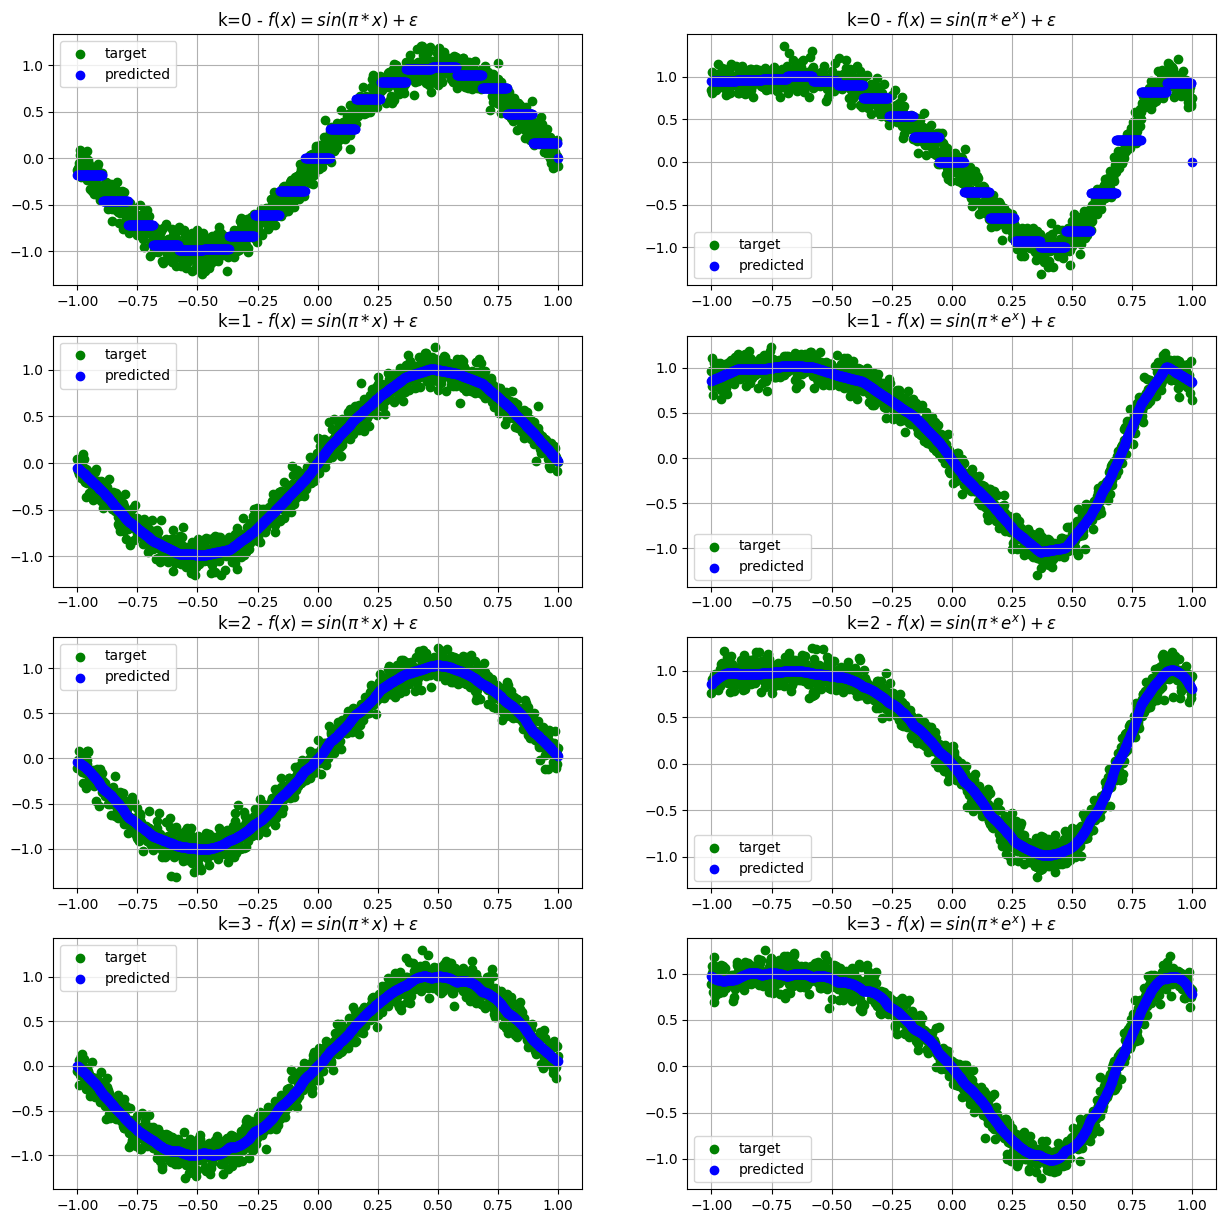

In [13]:
fns = []
fns += [(lambda x: torch.sin(torch.pi * x) + 0.1 * torch.randn(x.shape), '$f(x) = sin(\pi*x) + \epsilon$')]
fns += [(lambda x: torch.sin(torch.pi * torch.exp(x)) + 0.1 * torch.randn(x.shape), '$f(x) = sin(\pi*e^{x}) + \epsilon$')]

all_basis = [
        (eval_basis_functions(x_, grid_, k=0), 'k=0'), 
        (eval_basis_functions(x_, grid_, k=1), 'k=1'), 
        (eval_basis_functions(x_, grid_, k=2), 'k=2'), 
        (eval_basis_functions(x_, grid_, k=3), 'k=3')
]

fig, axs = plt.subplots(ncols=len(fns), nrows=len(all_basis), figsize=(15, 15), dpi=100)

for i in range(len(all_basis)):
    for j in range(len(fns)):
    
        ax = axs[i, j] 
        value, label = all_basis[i]
        fn, fn_label = fns[j]

        y_target = fn(x)
        coeff = torch.linalg.lstsq(value.squeeze(1), y_target).solution # find the coefficients 
        y_pred = torch.einsum('i, ji -> j', coeff, value.squeeze(1)) # use these coefficients to evaluate y
        
        ax.scatter(x, y_target, color='green', label='target')
        ax.scatter(x, y_pred, color='blue', label="predicted")

        ax.grid()
        ax.set_title(f"{label} - {fn_label}")
        ax.legend()